In [1]:
import json
import requests
import os
import zipfile
import geopandas as gpd
import pandas as pd
import io
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_co=pd.read_csv('/work/Coahuila/conjunto_de_datos_ageb_urbana_05_cpv2020.csv')
df_co.shape

(61056, 230)

In [3]:
df_co.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,5,Coahuila de Zaragoza,0,Total de la entidad Coahuila de Zaragoza,0,Total de la entidad,0000,0,3146771,1583102,...,372132,824291,519599,443659,195883,124077,17020,46420,332298,5754
1,5,Coahuila de Zaragoza,1,Abasolo,0,Total del municipio,0000,0,1022,487,...,46,318,40,187,14,21,7,28,265,4
2,5,Coahuila de Zaragoza,1,Abasolo,1,Total de la localidad urbana,0000,0,735,362,...,40,223,31,131,12,20,3,15,175,*
3,5,Coahuila de Zaragoza,1,Abasolo,1,Total AGEB urbana,0087,0,735,362,...,40,223,31,131,12,20,3,15,175,*
4,5,Coahuila de Zaragoza,1,Abasolo,1,Abasolo,0087,1,5,*,...,*,*,*,*,*,*,*,*,*,*


In [4]:
df_co = df_co.replace('*', pd.NA)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
df_co.isnull().sum()

ENTIDAD            0
NOM_ENT            0
MUN                0
NOM_MUN            0
LOC                0
               ...  
VPH_CVJ        21214
VPH_SINRTV     14702
VPH_SINLTC     20839
VPH_SINCINT    14208
VPH_SINTIC      8600
Length: 230, dtype: int64

In [5]:
df_co_limpio=df_co[['ENTIDAD','NOM_ENT','MUN','NOM_MUN','LOC','NOM_LOC','AGEB','MZA','POBTOT','P_12A14_F','P_15A49_F','P_0A2','P_3A5','P12YM_CASA','PCATOLICA','PRO_CRIEVA','POTRAS_REL','PSIN_RELIG','POCUPADA','GRAPROES','VPH_SINCINT','PDER_SS']]
df_co_limpio=df_co_limpio[df_co_limpio.apply(lambda row:all(row != '*'), axis=1)]
df_co_limpio=df_co_limpio[df_co_limpio.apply(lambda row:all(row != 'N/D'), axis=1)]
series_religiones=df_co_limpio['PCATOLICA'].astype('Int64')+df_co_limpio['PRO_CRIEVA'].astype('Int64')+df_co_limpio['POTRAS_REL'].astype('Int64')
series_14_a_59=df_co_limpio['P_12A14_F'].astype('Int64')+df_co_limpio['P_15A49_F'].astype('Int64')
df_co_limpio['P_0A2']=df_co_limpio['P_0A2'].astype('Int64')+df_co_limpio['P_3A5'].astype('Int64')
df_co_limpio.insert(13,'Personas_c_religion',series_religiones)
df_co_limpio.insert(8,'Mujeres_12_59',series_14_a_59)
df_co_limpio=df_co_limpio.drop(['PCATOLICA','PRO_CRIEVA','POTRAS_REL','P_12A14_F','P_15A49_F','P_3A5'],axis=1)
df_co_limpio.rename(columns={'PDER_SS':'Personas_servicio_salud','VPH_SINCINT': 'Personas_s_internet','GRAPROES': 'Prom_grado_escolar','POCUPADA': 'Personas_ocupadas','POBTOT': 'Poblacion_total','P12YM_CASA': 'Personas_casadas','P_0A2': 'Poblacion_0_5','PSIN_RELIG':'Personas_s_religion','PROM_HNV':'Promedio_nacidos','GRAP':'Personas_separadas'},inplace =True)

In [6]:
df_co_limpio.shape

(61044, 18)

In [7]:
df_co_limpio =df_co_limpio.dropna()
df_co_limpio.shape

(17880, 18)

In [8]:
df_co_limpio.query("~NOM_LOC.str.startswith('Total')",inplace=True)
df_co_limpio.shape

(16511, 18)

In [9]:
df_co_limpio['Personas_casadas']=df_co_limpio['Personas_casadas'].astype('Int64')
df_co_limpio["Personas_s_religion"] = df_co_limpio["Personas_s_religion"].astype("Int64")
df_co_limpio["Personas_ocupadas"] = df_co_limpio["Personas_ocupadas"].astype("Int64")
df_co_limpio["Prom_grado_escolar"] = df_co_limpio["Prom_grado_escolar"].astype("Float64")
df_co_limpio["Personas_s_internet"] = df_co_limpio["Personas_s_internet"].astype("Int64")
df_co_limpio["Personas_servicio_salud"] = df_co_limpio["Personas_servicio_salud"].astype("Int64")
df_co_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16511 entries, 6 to 61055
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ENTIDAD                  16511 non-null  int64  
 1   NOM_ENT                  16511 non-null  object 
 2   MUN                      16511 non-null  int64  
 3   NOM_MUN                  16511 non-null  object 
 4   LOC                      16511 non-null  int64  
 5   NOM_LOC                  16511 non-null  object 
 6   AGEB                     16511 non-null  object 
 7   MZA                      16511 non-null  int64  
 8   Mujeres_12_59            16511 non-null  Int64  
 9   Poblacion_total          16511 non-null  int64  
 10  Poblacion_0_5            16511 non-null  Int64  
 11  Personas_c_religion      16511 non-null  Int64  
 12  Personas_casadas         16511 non-null  Int64  
 13  Personas_s_religion      16511 non-null  Int64  
 14  Personas_ocupadas        16

In [10]:
df_co_limpio.isnull().sum()

ENTIDAD                    0
NOM_ENT                    0
MUN                        0
NOM_MUN                    0
LOC                        0
                          ..
Personas_s_religion        0
Personas_ocupadas          0
Prom_grado_escolar         0
Personas_s_internet        0
Personas_servicio_salud    0
Length: 18, dtype: int64

In [11]:
df_numerico = df_co_limpio.drop(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA'], axis=1)
df_numerico.head()

,Mujeres_12_59,Poblacion_total,Poblacion_0_5,Personas_c_religion,Personas_casadas,Personas_s_religion,Personas_ocupadas,Prom_grado_escolar,Personas_s_internet,Personas_servicio_salud
6,0,0,0,0,0,0,0,0.0,0,0
13,28,73,9,54,27,19,23,9.26,15,41
19,0,0,0,0,0,0,0,0.0,0,0
32,0,0,0,0,0,0,0,0.0,0,0
36,0,0,0,0,0,0,0,0.0,0,0


In [12]:
df_numerico.mode()

,Mujeres_12_59,Poblacion_total,Poblacion_0_5,Personas_c_religion,Personas_casadas,Personas_s_religion,Personas_ocupadas,Prom_grado_escolar,Personas_s_internet,Personas_servicio_salud
0,0,0,0,0,0,0,0,0.0,0,0


In [13]:
df_numerico.describe()

,Mujeres_12_59,Poblacion_total,Poblacion_0_5,Personas_c_religion,Personas_casadas,Personas_s_religion,Personas_ocupadas,Prom_grado_escolar,Personas_s_internet,Personas_servicio_salud
count,16511.0,16511.000000,16511.0,16511.0,16511.0,16511.0,16511.0,16511.0,16511.0,16511.0
mean,17.571377,57.706620,7.042457,50.116771,24.91654,7.458603,26.596935,5.139116,5.597299,46.926534
std,26.079308,83.883108,10.671532,74.76805,36.521564,13.127653,40.253806,5.278484,8.940274,69.426739
min,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,9.000000,0.0,7.0,4.0,0.0,4.0,6.43,0.0,5.0
75%,31.0,101.000000,12.0,87.0,44.0,11.0,46.0,9.91,9.0,81.0
max,433.0,1573.000000,194.0,1409.0,698.0,210.0,826.0,17.17,193.0,1335.0


In [14]:
df_numerico.median()

Mujeres_12_59               0.0
Poblacion_total             9.0
Poblacion_0_5               0.0
Personas_c_religion         7.0
Personas_casadas            4.0
Personas_s_religion         0.0
Personas_ocupadas           4.0
Prom_grado_escolar         6.43
Personas_s_internet         0.0
Personas_servicio_salud     5.0
dtype: Float64

In [15]:
print("Maximo: \n\n",df_numerico.max(),'\n')
print("Minimo: \n\n",df_numerico.min(),'\n')
print("Rango: \n\n",df_numerico.max()- df_numerico.min(),'\n')

Maximo: 

 Mujeres_12_59               433.0
Poblacion_total            1573.0
Poblacion_0_5               194.0
Personas_c_religion        1409.0
Personas_casadas            698.0
Personas_s_religion         210.0
Personas_ocupadas           826.0
Prom_grado_escolar          17.17
Personas_s_internet         193.0
Personas_servicio_salud    1335.0
dtype: Float64 

Minimo: 

 Mujeres_12_59              0.0
Poblacion_total            0.0
Poblacion_0_5              0.0
Personas_c_religion        0.0
Personas_casadas           0.0
Personas_s_religion        0.0
Personas_ocupadas          0.0
Prom_grado_escolar         0.0
Personas_s_internet        0.0
Personas_servicio_salud    0.0
dtype: Float64 

Rango: 

 Mujeres_12_59               433.0
Poblacion_total            1573.0
Poblacion_0_5               194.0
Personas_c_religion        1409.0
Personas_casadas            698.0
Personas_s_religion         210.0
Personas_ocupadas           826.0
Prom_grado_escolar          17.17
Personas_s_i

In [16]:
df_numerico.var()

Mujeres_12_59               680.130323
Poblacion_total            7036.375825
Poblacion_0_5               113.881601
Personas_c_religion        5590.261228
Personas_casadas           1333.824651
Personas_s_religion         172.335279
Personas_ocupadas          1620.368904
Prom_grado_escolar           27.862396
Personas_s_internet          79.928494
Personas_servicio_salud    4820.072071
dtype: Float64

In [17]:
df_numerico.std()

Mujeres_12_59              26.079308
Poblacion_total            83.883108
Poblacion_0_5              10.671532
Personas_c_religion         74.76805
Personas_casadas           36.521564
Personas_s_religion        13.127653
Personas_ocupadas          40.253806
Prom_grado_escolar          5.278484
Personas_s_internet         8.940274
Personas_servicio_salud    69.426739
dtype: Float64

In [18]:
df_cual = df_co_limpio.select_dtypes(exclude='number')
df_cual.head()

,NOM_ENT,NOM_MUN,NOM_LOC,AGEB
6,Coahuila de Zaragoza,Abasolo,Abasolo,0087
13,Coahuila de Zaragoza,Abasolo,Abasolo,0087
19,Coahuila de Zaragoza,Abasolo,Abasolo,0087
32,Coahuila de Zaragoza,Abasolo,Abasolo,0087
36,Coahuila de Zaragoza,Abasolo,Abasolo,0087


In [19]:
df_plot = df_co_limpio.drop(['ENTIDAD','NOM_ENT','MUN','LOC','NOM_LOC','AGEB','NOM_MUN','MZA'], axis = 1)

In [20]:
df_plot.columns

Index(['Mujeres_12_59', 'Poblacion_total', 'Poblacion_0_5',
       'Personas_c_religion', 'Personas_casadas', 'Personas_s_religion',
       'Personas_ocupadas', 'Prom_grado_escolar', 'Personas_s_internet',
       'Personas_servicio_salud'],
      dtype='object')

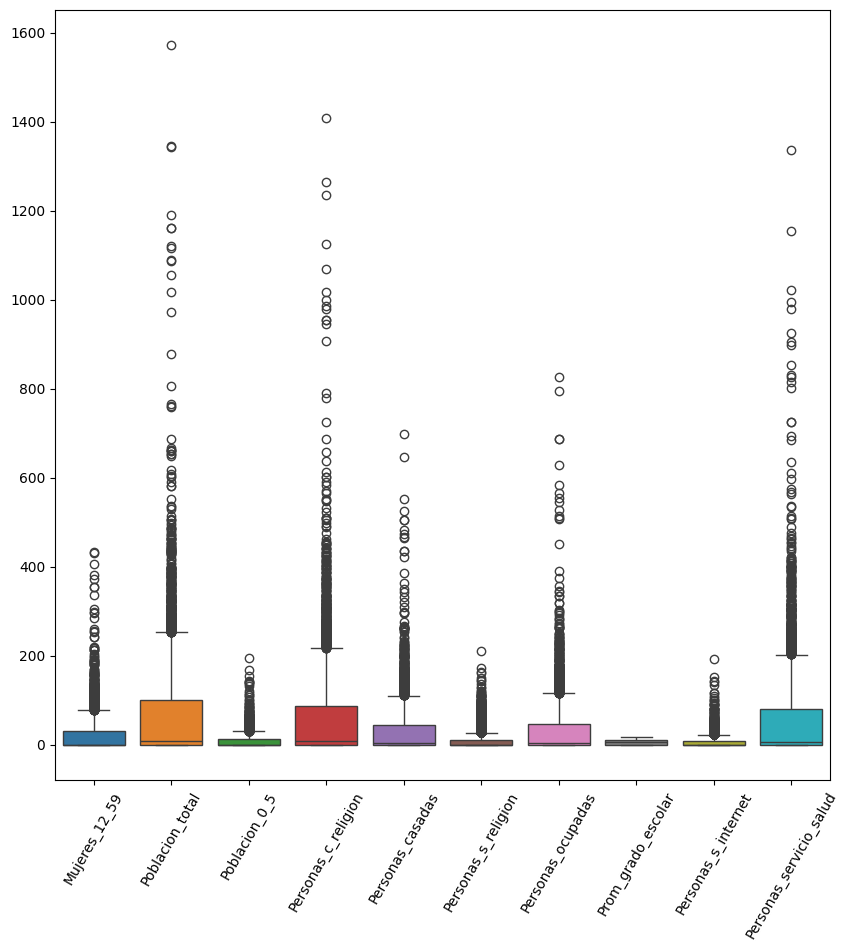

In [21]:
plt.figure(figsize=(10,10))
sns.boxplot(data = df_numerico.iloc[:,0:], orient='v', palette ='tab10')
plt.xticks(rotation = 60);

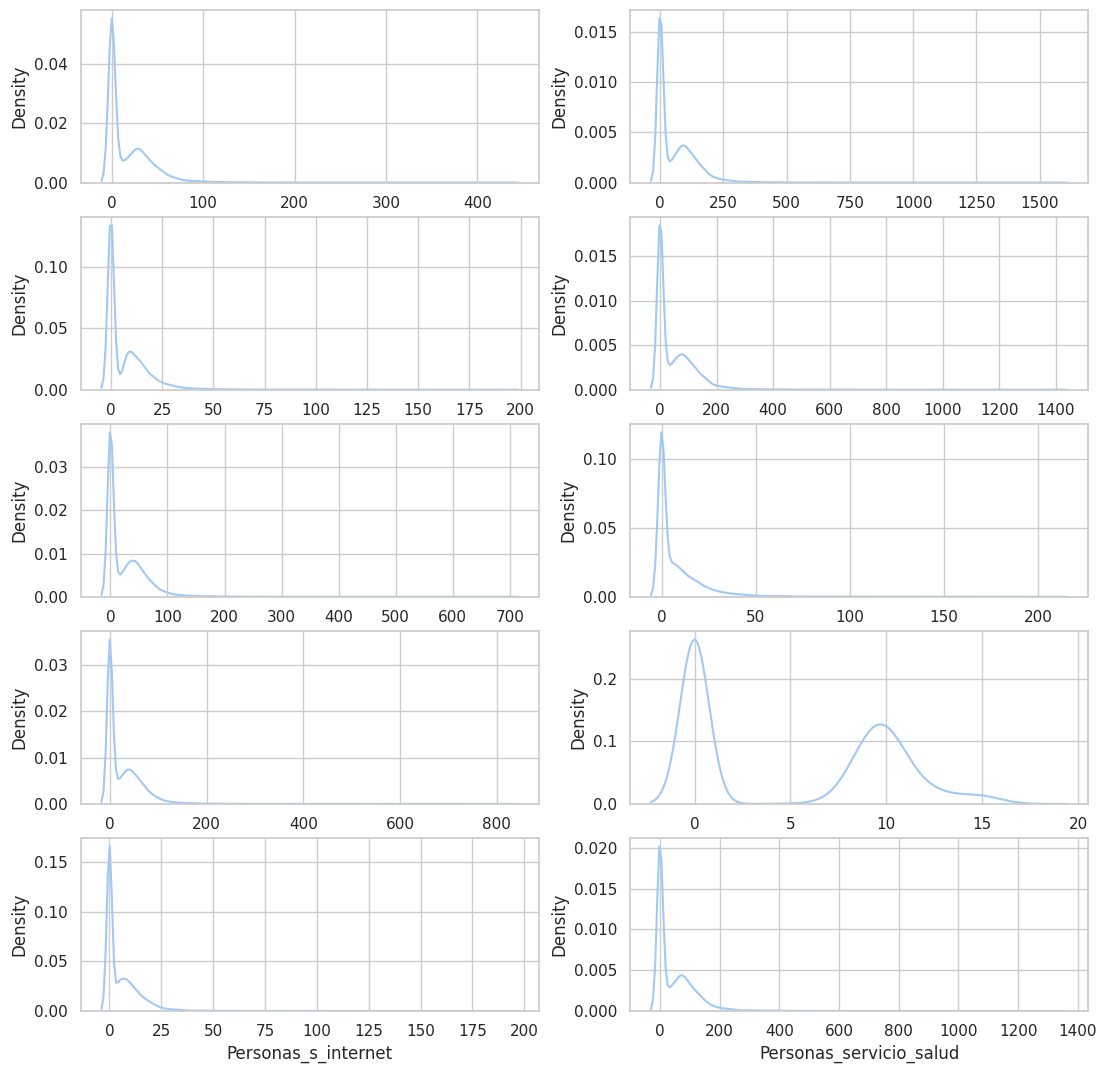

In [22]:
sns.set_theme(style = 'whitegrid', palette = 'pastel')
fig, axes =plt.subplots(nrows=5, ncols = 2, figsize = (13,13))
for i, ax in enumerate(axes.flatten()):
  sns.kdeplot(x = df_plot.iloc[:, i], ax = ax)
fig.show()

<AxesSubplot: >

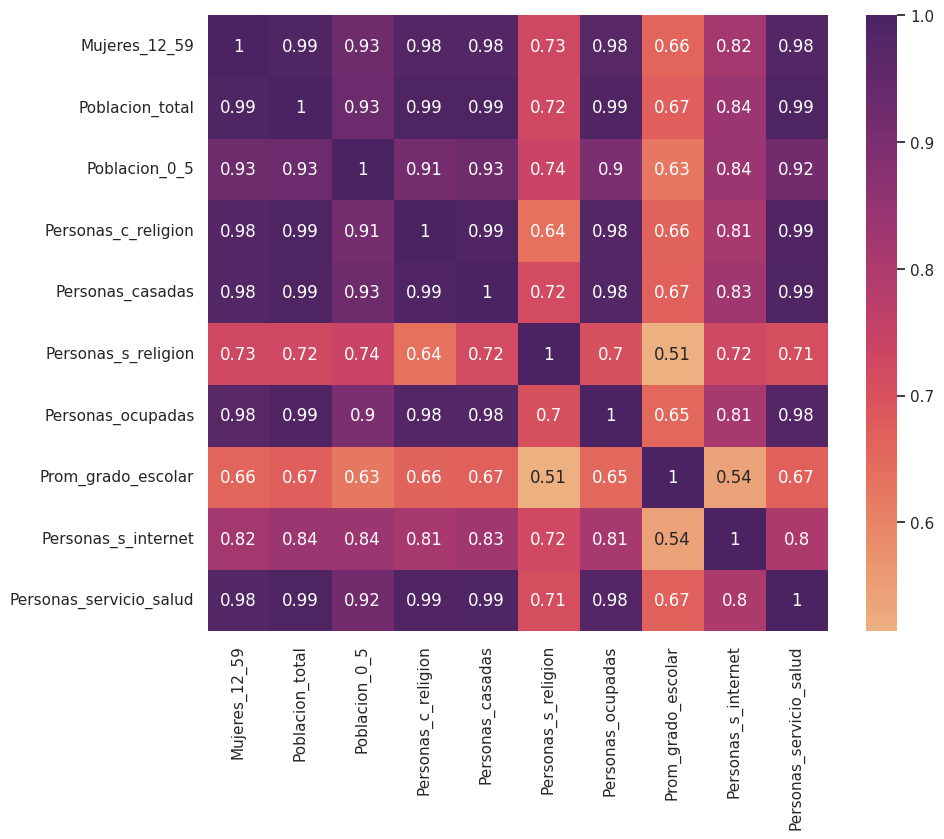

In [23]:
plt.figure(figsize = (10,8))
sns.heatmap(df_plot.corr(), annot=True, cmap = 'flare')

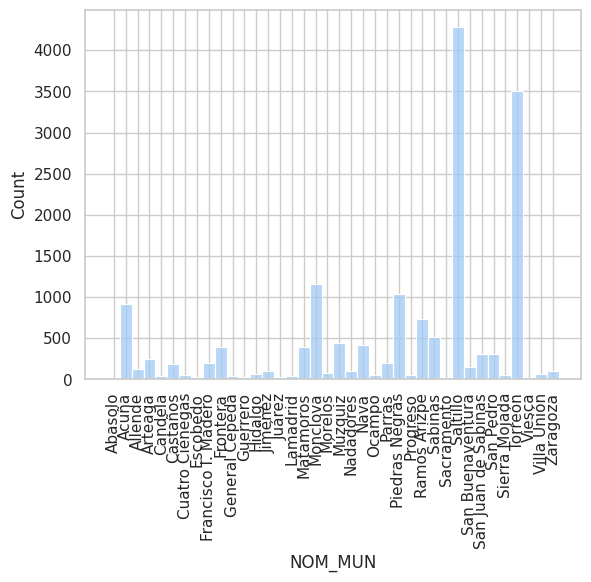

In [24]:
sns.histplot(data = df_cual, x = 'NOM_MUN')
plt.xticks(rotation = 90);

<AxesSubplot: xlabel='x', ylabel='Count'>

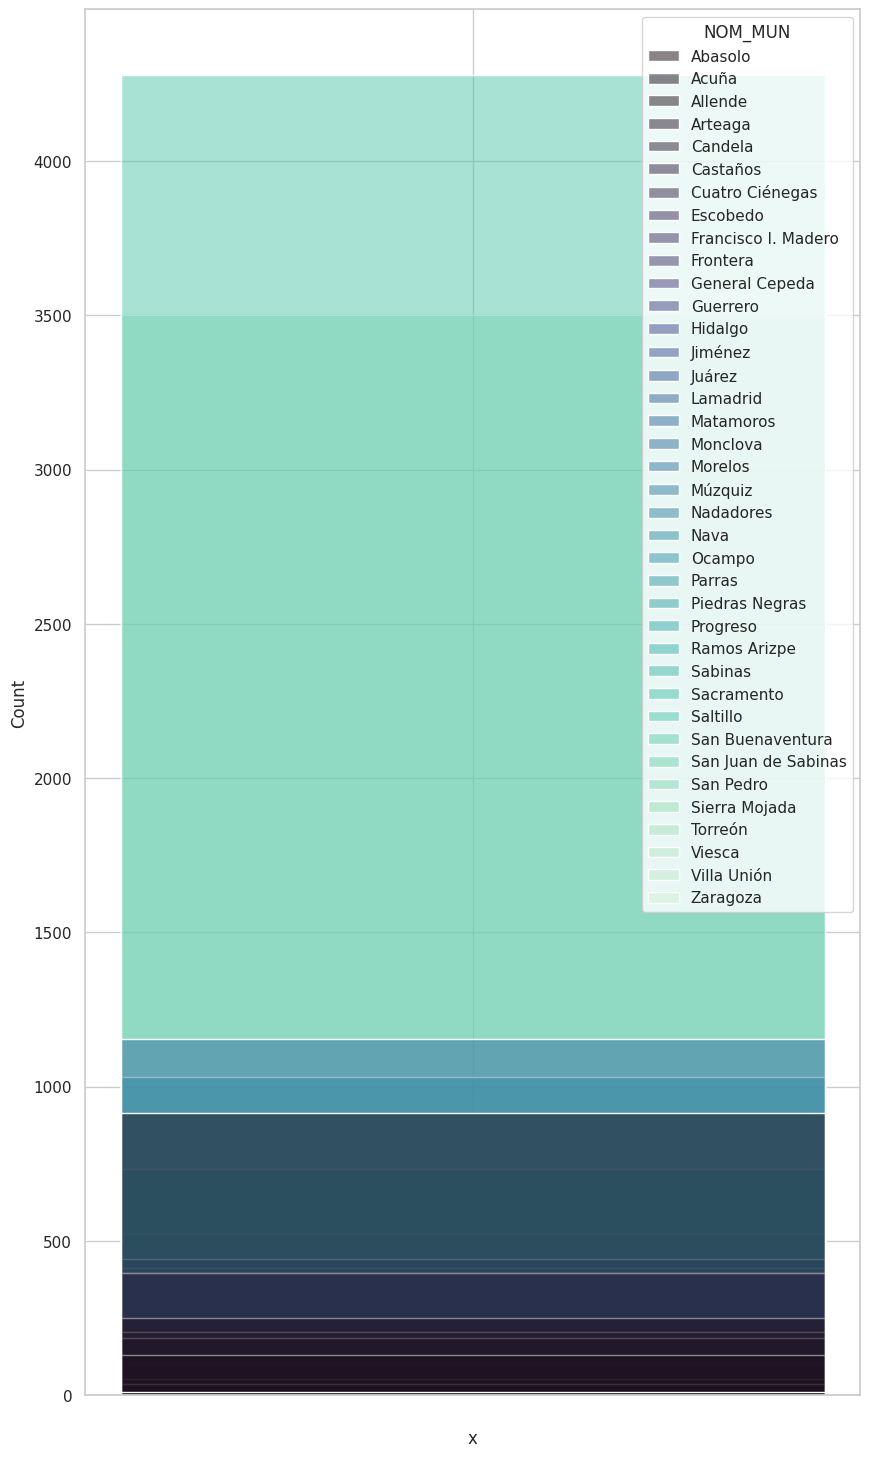

In [25]:
plt.figure(figsize = (10,18))
df_plot_cual = df_cual.copy()
df_plot_cual['x'] = ' '
sns.histplot(data = df_plot_cual, x = 'x', hue ='NOM_MUN', palette = 'mako')

In [26]:
print("Tabla de contingencia de nombre de estado para la población de 0 a 5 años:")
display(pd.crosstab(df_cual.iloc[:, 0], df_numerico["Poblacion_0_5"], normalize=True))
print("Tabla de contingencia de nombre de municipio para la población de 0 a 5 años:")
display(pd.crosstab(df_cual.iloc[:, 1], df_numerico["Poblacion_0_5"], normalize=True))
print("Tabla de contingencia de nombre de la localidad para la población de 0 a 5 años:")
display(pd.crosstab(df_cual.iloc[:, 2], df_numerico["Poblacion_0_5"], normalize=True))
print("Tabla de contingencia de AGEB para la población de 0 a 5 años:")
display(pd.crosstab(df_cual.iloc[:, 3], df_numerico["Poblacion_0_5"], normalize=True))

Tabla de contingencia de nombre de estado para la población de 0 a 5 años:


Poblacion_0_5,0,3,4,5,6,7,8,...,139,140,141,143,155,168,194
NOM_ENT,,,,,,,,,,,,,,,
Coahuila de Zaragoza,0.537763,0.014475,0.005996,0.003816,0.018836,0.027921,0.032584,...,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061,0.000061


Tabla de contingencia de nombre de municipio para la población de 0 a 5 años:


Poblacion_0_5,0,3,4,5,6,7,8,...,139,140,141,143,155,168,194
NOM_MUN,,,,,,,,,,,,,,,
Abasolo,0.000545,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Acuña,0.024226,0.001151,0.000363,0.000363,0.001575,0.001635,0.002120,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Allende,0.004906,0.000242,0.000121,0.000000,0.000182,0.000424,0.000363,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Arteaga,0.012961,0.000182,0.000000,0.000000,0.000061,0.000061,0.000424,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Candela,0.002241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sierra Mojada,0.002604,0.000121,0.000000,0.000000,0.000000,0.000000,0.000242,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Torreón,0.115135,0.002362,0.001030,0.000787,0.003876,0.005693,0.006602,...,0.000061,0.000061,0.000061,0.000061,0.0,0.000061,0.000061
Viesca,0.000969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


Tabla de contingencia de nombre de la localidad para la población de 0 a 5 años:


Poblacion_0_5,0,3,4,5,6,7,8,...,139,140,141,143,155,168,194
NOM_LOC,,,,,,,,,,,,,,,
Abasolo,0.000545,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Allende,0.004906,0.000242,0.000121,0.000000,0.000182,0.000424,0.000363,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Arteaga,0.012598,0.000121,0.000000,0.000000,0.000000,0.000061,0.000363,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Candela,0.002241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Castaños,0.006783,0.000242,0.000061,0.000000,0.000424,0.000787,0.000485,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sierra Mojada,0.001514,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Torreón,0.113379,0.002362,0.001030,0.000727,0.003876,0.005390,0.006602,...,0.000061,0.000061,0.000061,0.000061,0.0,0.000061,0.000061
Viesca,0.000969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


Tabla de contingencia de AGEB para la población de 0 a 5 años:


Poblacion_0_5,0,3,4,5,6,7,8,...,139,140,141,143,155,168,194
AGEB,,,,,,,,,,,,,,,
0011,0.000363,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0013,0.000545,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0015,0.000061,0.000000,0.000061,0.0,0.000000,0.000061,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0017,0.000787,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0019,0.000363,0.000061,0.000061,0.0,0.000121,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0.000485,0.000000,0.000000,0.0,0.000000,0.000000,0.000061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5836,0.000424,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5840,0.000182,0.000061,0.000000,0.0,0.000061,0.000000,0.000061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

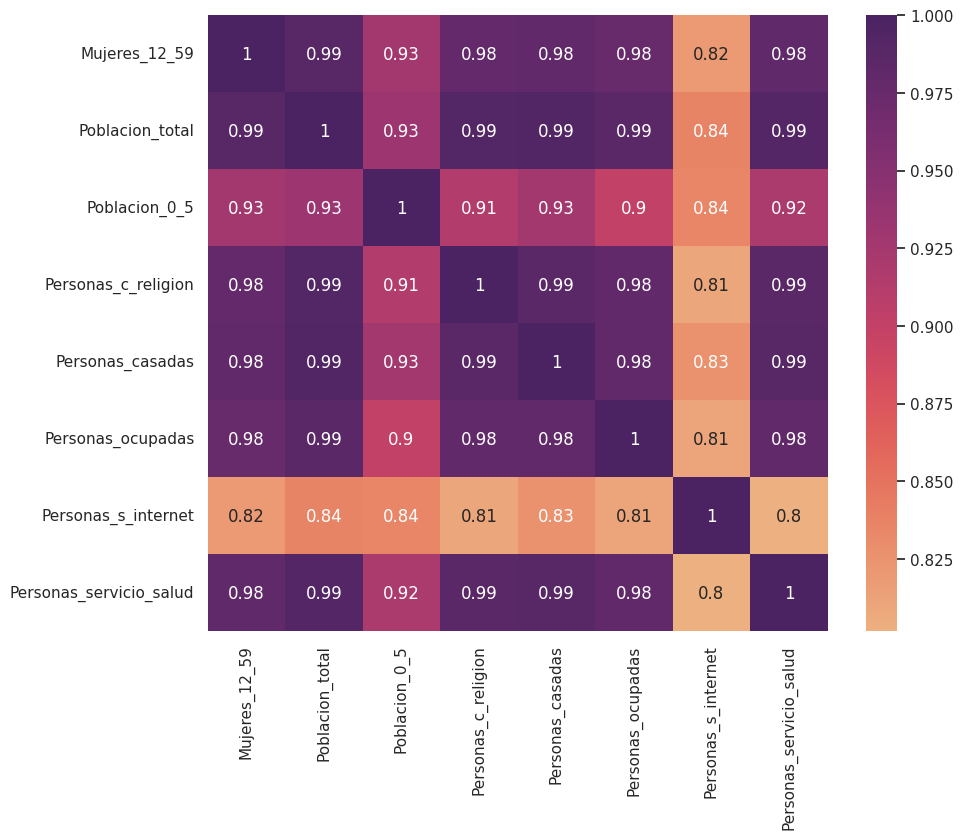

In [27]:
#Guardar la bsae de datos sin la variable que menos correlacion tenga 
df_export = df_plot.drop(['Prom_grado_escolar', 'Personas_s_religion'], axis = 1)
plt.figure(figsize = (10,8))
sns.heatmap(df_export.corr(), annot=True, cmap = 'flare')

In [28]:
#df_export.to_csv('df_coah_corr.csv', index = True)
#Estos datos ya no se van a utilizar, debido a una falta de estandarizacion
#Se tomo en consideracion realizar una trans. logaritmica

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0848c89-aa3f-4842-a14c-1735a6491904' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>